In [37]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common import TimeoutException
import os
import pandas as pd
from bs4 import BeautifulSoup
from langdetect import detect
from readability import Readability
import re
import nltk
from tqdm.notebook import tqdm
tqdm.pandas()

In [35]:
def numWords(text):
    r = Readability(str(text))
    try:
        t = r.statistics()
        return t['num_words']
    except:
        return None


def removeHTML(html_str):
    soup = BeautifulSoup(str(html_str), features="html.parser")
    return soup.get_text()


def remove_urls(document):
    document = re.sub(r'http\S+', '', str(document))
    return document


def remove_parting_lines(document):
    pattern = r'^[\*\-#]{5,}.+$'
    document = re.sub(pattern, '', str(document), flags=re.MULTILINE)
    return document


def detectLang(t):
    try:
        return detect(t)
    except:
        return None

In [33]:
df_kickstarter_raw = pd.read_csv('../kickstarter.csv')

In [38]:
# every 100th datapoint
df_kickstarter = df_kickstarter_raw.iloc[::100, :]
# Filter rows based on column: 'project_country'
df_kickstarter = df_kickstarter[df_kickstarter['project_country'] == "US"]
# Filter rows based on column: 'project_currency'
df_kickstarter = df_kickstarter[df_kickstarter['project_currency'] == "USD"]
# Drop rows with missing data in column: 'project_title'
df_kickstarter = df_kickstarter.dropna(subset=['project_title'])
# Drop rows with missing data in column: 'project_description'
df_kickstarter = df_kickstarter.dropna(subset=['project_title'])
# Drop duplicate rows in column: 'project_description'
df_kickstarter = df_kickstarter.drop_duplicates(subset=['project_description'])
nltk.download('punkt')
df_kickstarter['num_words'] = df_kickstarter['project_description'].progress_apply(numWords)
df_kickstarter = df_kickstarter[df_kickstarter['num_words'] >= 100]
df_kickstarter['project_lang'] = df_kickstarter['project_description'].progress_apply(detectLang)
df_kickstarter = df_kickstarter[df_kickstarter['project_lang'] == 'en']

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\CoolerMaster\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


  0%|          | 0/3861 [00:00<?, ?it/s]

  0%|          | 0/3559 [00:00<?, ?it/s]

In [39]:
# Create new Grammarly Column
df_kickstarter['grammarly_performance'] = ""

# Set the path to your text files
text_files_path = 'D:/Uni/Bachelorthesis/Thesis Selenium/txtfiles'

# Get a list of all files in the directory
files = os.listdir(text_files_path)

# Sort the files based on their numerical value
sorted_files = sorted(files, key=lambda x: int(x.split('.')[0]))

# Get the row indices from the filtered DataFrame
filtered_indices = df_kickstarter.index.tolist()
# Filter the sorted_files list based on the row indices
filtered_files = [filename for filename in sorted_files if int(filename.split('.')[0]) in filtered_indices]

# Set the path to your Chrome user profile directory
chrome_profile_path = 'C:/Users/CoolerMaster/AppData/Local/Google/Chrome/User Data'

# Specify the path to the ChromeDriver executable
chromedriver_path = 'D:/Uni/Bachelorthesis/Thesis Selenium/chromedriver.exe'

# Create a Service object
service = Service(chromedriver_path)

# Set Chrome options to run in app mode
chrome_options = Options()
chrome_options.add_argument(f'--user-data-dir={chrome_profile_path}')
chrome_options.binary_location = 'C:/Program Files (x86)/Google/Chrome/Application/chrome.exe'

In [ ]:
print(filtered_indices)

In [ ]:
print(filtered_files)

In [66]:
# Initialize the Chrome WebDriver with the options
driver = webdriver.Chrome(service=service, options=chrome_options)

#start_filename = "292500.txt"

#start_index = filtered_files.index(start_filename)

# Loop through the text files and upload each file
for filename in filtered_files:#[start_index:]:

    # Navigate to Grammarly Editor
    driver.get('https://app.grammarly.com/')

    retry = True
    while retry:
        # Wait for the page to load
        wait = WebDriverWait(driver, 10)
        wait.until(EC.presence_of_element_located((By.ID, 'upload')))

        # Find the file upload button
        upload_button = driver.find_element(By.ID, 'upload')

        file_path = os.path.join(text_files_path, filename)

        # Provide the file path to the file upload input field
        upload_button.send_keys(file_path)

        try:
            wait.until(EC.url_changes('https://app.grammarly.com/'))
            retry = False
        except TimeoutException:
            # Refresh the browser and repeat the iteration
            driver.refresh()

    retry = True
    while retry:
        try:
           # Wait for the notification close icon to appear and click it
            wait.until(EC.element_to_be_clickable((By.CLASS_NAME, 'f2phmyy.notifications-closeIconWrapper_f7j52aq.f17uf1gk')))
            close_icon = driver.find_element(By.CLASS_NAME, 'f2phmyy.notifications-closeIconWrapper_f7j52aq.f17uf1gk')
            close_icon.click()

            # Wait for the done button to appear and click it
            wait.until(EC.element_to_be_clickable((By.CLASS_NAME, 'fqlvlsm.f2phmyy.fns4yay')))
            done_button = driver.find_element(By.CLASS_NAME, 'fqlvlsm.f2phmyy.fns4yay')
            done_button.click()

            # Extract the performance score
            wait.until(EC.presence_of_element_located((By.CLASS_NAME, 'fal6plv.navigation-outcomeBtn_f160k9oy.navigation-outcomeBtnBorders_ffjervb._94f802ae-header-performanceBtnHigh._c37af1c2-header-headerBtn.f17uf1gk')))
            performance_score_element = driver.find_element(By.CLASS_NAME, 'fal6plv.navigation-outcomeBtn_f160k9oy.navigation-outcomeBtnBorders_ffjervb._94f802ae-header-performanceBtnHigh._c37af1c2-header-headerBtn.f17uf1gk')
            performance_score_string = performance_score_element.get_attribute('aria-label')
            while performance_score_string == "Calculating...":
                performance_score_string = performance_score_element.get_attribute('aria-label')
            retry = False
        except TimeoutException:
            driver.refresh()
            try:
                # Wait for the done button to appear and click it
                wait.until(EC.element_to_be_clickable((By.CLASS_NAME, 'fqlvlsm.f2phmyy.fns4yay')))
                done_button = driver.find_element(By.CLASS_NAME, 'fqlvlsm.f2phmyy.fns4yay')
                done_button.click()

                # Extract the performance score
                wait.until(EC.presence_of_element_located((By.CLASS_NAME, 'fal6plv.navigation-outcomeBtn_f160k9oy.navigation-outcomeBtnBorders_ffjervb._94f802ae-header-performanceBtnHigh._c37af1c2-header-headerBtn.f17uf1gk')))
                performance_score_element = driver.find_element(By.CLASS_NAME, 'fal6plv.navigation-outcomeBtn_f160k9oy.navigation-outcomeBtnBorders_ffjervb._94f802ae-header-performanceBtnHigh._c37af1c2-header-headerBtn.f17uf1gk')
                performance_score_string = performance_score_element.get_attribute('aria-label')
                while performance_score_string == "Calculating...":
                    performance_score_string = performance_score_element.get_attribute('aria-label')
                retry = False
            except TimeoutException:
                driver.refresh()
                try:
                    # Extract the performance score
                    wait.until(EC.presence_of_element_located((By.CLASS_NAME, 'fal6plv.navigation-outcomeBtn_f160k9oy.navigation-outcomeBtnBorders_ffjervb._94f802ae-header-performanceBtnHigh._c37af1c2-header-headerBtn.f17uf1gk')))
                    performance_score_element = driver.find_element(By.CLASS_NAME, 'fal6plv.navigation-outcomeBtn_f160k9oy.navigation-outcomeBtnBorders_ffjervb._94f802ae-header-performanceBtnHigh._c37af1c2-header-headerBtn.f17uf1gk')
                    performance_score_string = performance_score_element.get_attribute('aria-label')
                    while performance_score_string == "Calculating...":
                        performance_score_string = performance_score_element.get_attribute('aria-label')
                    retry = False
                except TimeoutException:
                    driver.refresh()
    #print(f'Performance score string for {filename}: {performance_score_string}')
    if performance_score_string == "Text is too short":
        continue
    # Extract the performance score substring
    start_index = performance_score_string.index(':') + 1
    end_index = performance_score_string.index('%')
    performance_score = performance_score_string[start_index:end_index].strip()

    print(f'Performance score for {filename}: {performance_score}')
    df_kickstarter.at[int(filename.split('.')[0]), 'grammarly_performance'] = performance_score

# Quit the browser
driver.quit()

Performance score for 292500.txt: 81
Performance score for 292800.txt: 73
Performance score for 292900.txt: 79
Performance score for 293100.txt: 67
Performance score for 293400.txt: 70
Performance score for 293500.txt: 78
Performance score for 293600.txt: 80
Performance score for 294000.txt: 56
Performance score for 294100.txt: 77
Performance score for 294200.txt: 83
Performance score for 294300.txt: 56
Performance score for 294400.txt: 81
Performance score for 294500.txt: 73
Performance score for 294600.txt: 73
Performance score for 294700.txt: 61
Performance score for 294800.txt: 79
Performance score for 295100.txt: 57
Performance score for 295300.txt: 55
Performance score for 295400.txt: 82
Performance score for 295600.txt: 51
Performance score for 295700.txt: 74
Performance score for 295800.txt: 35
Performance score for 295900.txt: 79
Performance score for 296000.txt: 76
Performance score for 296200.txt: 64
Performance score for 296400.txt: 59
Performance score for 296500.txt: 75
P

In [67]:
df_kickstarter.head(4000)

,project_id,project_url,project_video_url,project_title,project_blurb,project_creator_id,project_location,project_country,project_category_id,project_parent_category_id,...,project_rewards,project_launched_at,project_successful_at,project_deadline,project_staff_pick,project_creator_project_number,project_description,num_words,project_lang,grammarly_performance
0,1.860890e+09,https://www.kickstarter.com/projects/perry/gra...,https://ksr-video.imgix.net/projects/3/video-1...,Grace Jones Does Not Give A F$#% T-Shirt (limi...,About two years ago I realized a profound trut...,4.000000e+00,Brooklyn,US,9.0,NaN,...,1.0,2009-04-21 21:02:48,NaN,2009-05-31 08:59:59,0.0,1.0,About two years ago I realized a profound trut...,130.0,en,79
100,1.808852e+09,https://www.kickstarter.com/projects/chrismcka...,https://ksr-video.imgix.net/projects/216/video...,Music Lovers Unite For The Critical Darlings,Hi. I&#39;m Chris McKay from The Critical Darl...,3.420104e+08,Athens,US,42.0,14.0,...,17.0,2009-06-05 16:11:07,NaN,2009-09-02 19:13:00,0.0,1.0,Hi! I'm Chris McKay from The Critical Darlings...,1835.0,en,86
200,1.063798e+08,https://www.kickstarter.com/projects/andrewa/n...,https://ksr-video.imgix.net/projects/447/video...,Native Shout: Take Back Your Music!,"Not your corporate music distribution company,...",1.037686e+09,New York,US,14.0,NaN,...,7.0,2009-08-09 20:53:15,NaN,2009-11-07 05:59:00,0.0,1.0,NATIVE SHOUT is a digital music website (e.g. ...,210.0,en,83
300,1.030981e+09,https://www.kickstarter.com/projects/118510390...,NaN,Egg on Bread News,A humorous fictional newspaper filled with art...,1.185104e+09,New York,US,13.0,NaN,...,8.0,2009-08-23 19:02:36,2009-10-24 06:00:06,2009-10-24 05:59:00,0.0,1.0,What we would like to do is create a 20 page 1...,120.0,en,75
400,1.075468e+09,https://www.kickstarter.com/projects/200583245...,NaN,SuperGlue - get art to fund art! (Canceled),SuperGlue has a number of large scale public a...,2.005832e+09,New York,US,1.0,NaN,...,5.0,2009-09-08 02:15:05,NaN,2009-10-05 05:59:00,0.0,1.0,SuperGlue recently received funding to paint a...,242.0,en,87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
573900,2.143052e+09,https://www.kickstarter.com/projects/stevenrus...,NaN,Drawings of the Major Arcana Tarot,A Drawn Tarot Set of the Major 22 Card Arcana,1.135699e+09,San Rafael,US,273.0,12.0,...,39.0,2023-02-15 16:00:21,2023-03-17 15:00:21,2023-03-17 15:00:21,0.0,8.0,I'm raising funds to create my first Tarot Dec...,182.0,en,78
574000,1.052384e+09,https://www.kickstarter.com/projects/cordellco...,https://v2.kickstarter.com/1679261704-%2FOAkJp...,The Pro Wrestling Documentary,An intimate look into the lives of five wrestl...,8.573235e+08,Rochester,US,30.0,11.0,...,7.0,2023-02-26 16:01:02,NaN,2023-03-18 15:01:02,0.0,6.0,You either love or hate professional wrestling...,463.0,en,90
574300,9.494136e+08,https://www.kickstarter.com/projects/batemanac...,NaN,Commercial Kitchen for Bateman Acres,"We make small batch handcrafted jams, Gluten f...",1.655997e+09,Mount Vernon,US,313.0,10.0,...,4.0,2023-01-21 05:53:34,NaN,2023-03-22 02:45:00,0.0,1.0,"My name is Jamie Williams, also known as “Momm...",644.0,en,83
574400,1.394640e+09,https://www.kickstarter.com/projects/miniature...,https://v2.kickstarter.com/1679540348-%2BsNIjW...,Crazed - Anniversary Mega Bundle,"150 ""Pre-Supported"" STL miniatures files for 3...",8.059237e+08,Charlotte,US,34.0,12.0,...,10.0,2023-03-07 14:00:40,2023-03-21 17:59:04,2023-03-21 17:59:00,0.0,10.0,"March 2020 I announced my Patreon and with it,...",762.0,en,57


In [68]:
# Save the updated DataFrame to a CSV file
df_kickstarter.to_csv('kickstarter_grammarly_dirty.csv')

In [86]:
df_kickstarter['date'] = pd.to_datetime(df_kickstarter['project_launched_at'])
df_kickstarter_grouped_date = df_kickstarter.groupby('date')['grammarly_performance'].mean().reset_index()

In [87]:
df_kickstarter_grouped_date = df_kickstarter_grouped_date.sort_values('date')

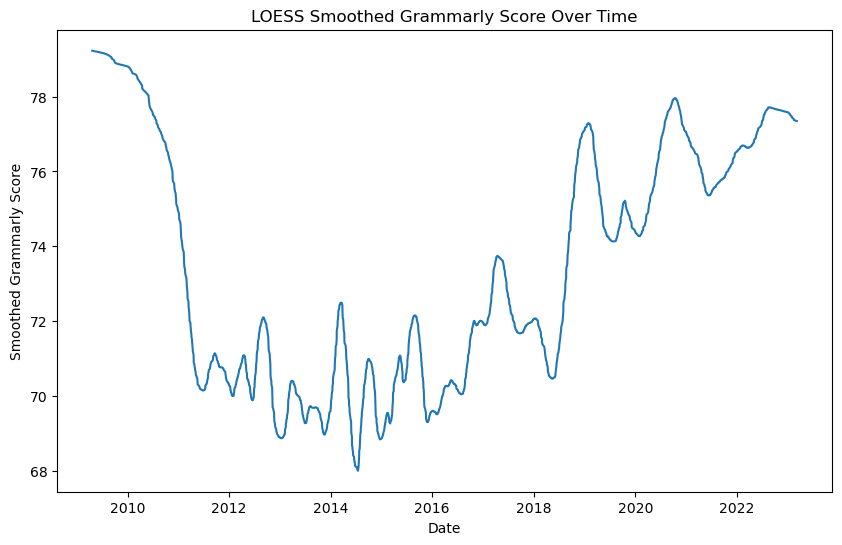

In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
# Apply LOESS smoothing
lowess = sm.nonparametric.lowess(df_kickstarter_grouped_date['grammarly_performance'], df_kickstarter_grouped_date.index, frac=0.05)

plt.figure(figsize=(10, 6))
plt.plot(df_kickstarter_grouped_date['date'], lowess[:, 1])
plt.xlabel('Date')
plt.ylabel('Smoothed Grammarly Score')
plt.title('LOESS Smoothed Grammarly Score Over Time')
plt.show()

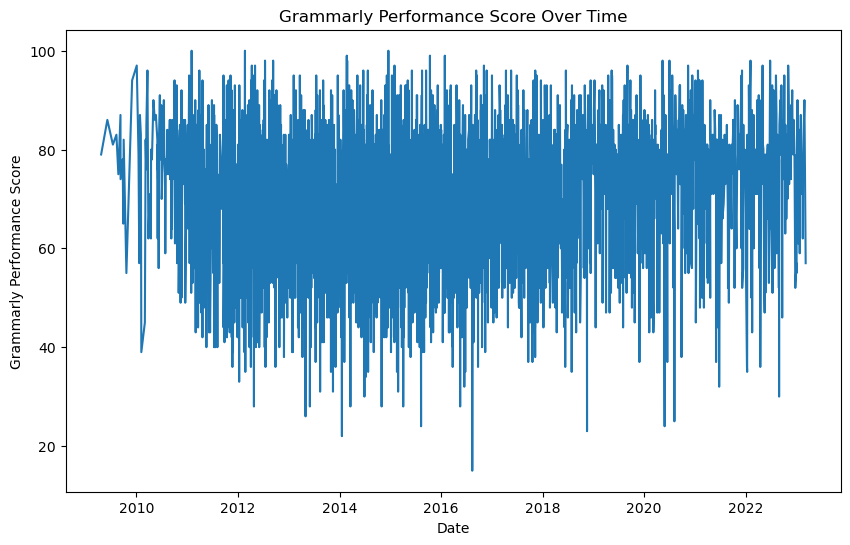

In [89]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_kickstarter_grouped_date, x='date', y='grammarly_performance')
plt.xlabel('Date')
plt.ylabel('Grammarly Performance Score')
plt.title('Grammarly Performance Score Over Time')
plt.show()